In [1]:
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import scipy.optimize
from scipy.optimize import curve_fit
import random


In [2]:
# In this notebook, we will compare the ns time distribtions for data and MC.
# There is also an example of how to re-calculate the reconstructed time
# We can eventually expand this to fully utlize the spacepoints and/or incorporate additional/alternative calibrations.

## Set the following to your file paths

In [3]:
######################### Change these paths #########################
bnb_data_filename = "/Users/bbogart/Documents/data/validation_MCC9.10/10_04_07_05/hyper/raw/SURPRISE_Test_Samples_v10_04_07_05_Run4b_hyper_unified_reco2_BNB_beam_on_may8_reco2_hist_goodruns_62280934_snapshot.root"
bnb_MC_filename = "/Users/bbogart/Documents/data/validation_MCC9.10/10_04_07_05/hyper/raw/SURPRISE_Test_Samples_v10_04_07_05_Run4b_hyper_unified_reco2_BNB_nu_overlay_may8_reco2_hist_62280499_snapshot.root"

numi_data_filename = "/Users/bbogart/Documents/data/validation_MCC9.10/10_04_07_05/hyper/raw/SURPRISE_Test_Samples_v10_04_07_05_Run4b_hyper_unified_reco2_numi_beam_on_may8_reco2_hist_goodruns_62280899_snapshot.root"
numi_MC_filename = "/Users/bbogart/Documents/data/validation_MCC9.10/10_04_07_05/hyper/raw/SURPRISE_Test_Samples_v10_04_07_05_Run4b_hyper_unified_reco2_NuMI_nu_overlay_may8_reco2_hist_62280486_snapshot.root"


In [4]:
bnb_gap = 18.936
numi_gap = 18.831

In [5]:
#Used for performing the guassian fit
def gaus(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + offset

#helper function to get bin centers
def get_bin_centers(x):
    centers = []
    for i in range(len(x)-1): centers.append( x[i] + (x[i+1]-x[i])/2 )
    return centers

## Plot the merged beam peak for the BNB data
No special steps, we will first just use the time "out of the box"

In [6]:
#load in the BNB data
file = uproot.open(bnb_data_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS","run","subrun","event"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_bnb_data = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_bnb_data.shape[0])
df_bnb_data = df_bnb_data.query("evtTimeNS>0")
print(df_bnb_data.shape[0])

540998
28531


In [7]:
#merge everything into a single peak with the run dependent corrections
run = df_bnb_data["run"].to_numpy()
evtTimeNS = df_bnb_data["evtTimeNS"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):
    
    if np.nan_to_num(evtTimeNS[i],nan=-999999,posinf=-999999,neginf=-999999)<=0:
        new_times.append(-9999)
        continue   
         
    gap=bnb_gap
    Shift=0
    TThelp=0
    if (run[i] >= 19500): Shift=2920.5-0.2 
    elif (run[i] >= 17380): Shift=2916.0 
    elif (run[i] >= 13697): Shift = 3147.3
    elif (run[i] >= 10812): Shift = 3568.5 
    elif (run[i] >= 8321): Shift = 3610.7
    elif (run[i] >= 5800): Shift = 3164.4
    elif (run[i] > 0 ): Shift = 3168.9
    TThelp = evtTimeNS[i]-Shift+gap*0.5
    TT_merged = -9999.

    if(TThelp>=0 and TThelp<gap*81.0): 
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_bnb_data["merge_time"] = new_times

data: Gaussian      mean: 0.0037   std: -2.6356   C: 75.9465


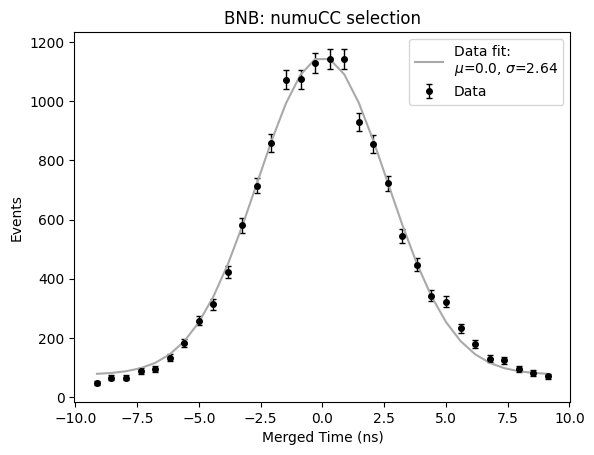

In [8]:
#plot the merged time peak

nbins = 32

data = df_bnb_data.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["merge_time"].to_numpy()
y,xbins = np.histogram(data,bins=nbins,range=(-9.42, 9.42))

x = get_bin_centers(xbins)

popt,pcov = curve_fit(gaus,x,y)
print("data: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))


plt.figure()
plt.title("BNB: numuCC selection")
plt.errorbar(get_bin_centers(xbins),y,yerr=np.sqrt(y),ms=8, lw=1,fmt='.',ecolor = 'black',color='black', capsize=2, capthick=1, label="Data")
plt.plot(x,gaus(x,*popt),color='darkgray',label='Data fit:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")
plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.legend()
plt.show()

In [9]:
#load in the bnb MC
file = uproot.open(bnb_MC_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS_cor","run","subrun","event"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_bnb_mc = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_bnb_mc.shape[0])
df_bnb_mc = df_bnb_mc.query("evtTimeNS_cor>0")
print(df_bnb_mc.shape[0])

93745
30491


In [10]:
#merge everything into a single peak
#you may have to play around with Shift to get things aligned at 0
evtTimeNS = df_bnb_mc["evtTimeNS_cor"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):
    
    if np.nan_to_num(evtTimeNS[i],nan=-999999,posinf=-999999,neginf=-999999)<=0:
        new_times.append(-9999)
        continue  
        
    gap=bnb_gap
    Shift=5.5
    TThelp=0

    TThelp = evtTimeNS[i]-Shift+gap*0.5

    TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_bnb_mc["merge_time"] = new_times

overlay: Gaussian      mean: -0.0069   std: 2.6368   C: 0.0048
data: Gaussian      mean: 0.0037   std: 2.6356   C: 0.0052


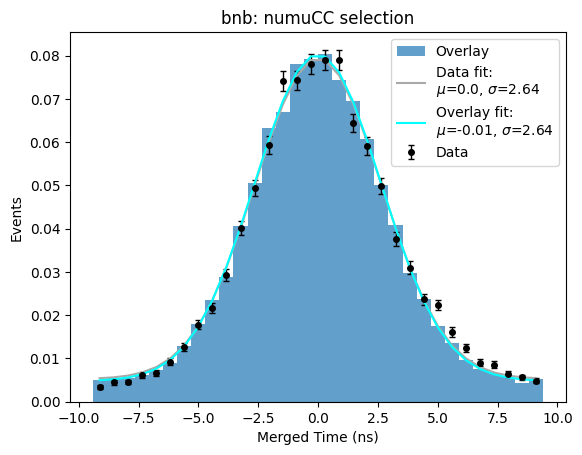

In [11]:
nbins = 32

emulate_ext = True

data = df_bnb_data.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["merge_time"].to_numpy()
y,xbins = np.histogram(data,bins=nbins,range=(-9.42, 9.42))

#only using overlay for now, eventually we can move towards a full data to MC comparison that includes EXT and Dirt
overlay = df_bnb_mc.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["merge_time"].to_numpy()
weights = np.ones_like(df_bnb_mc.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["merge_time"].to_numpy())
if(emulate_ext):
    ext = np.random.uniform(-9.42, 9.42, size=int(len(overlay)*0.1))
    overlay = np.concatenate((overlay,ext))
weight = np.ones_like(overlay)*len(data)/len(overlay)
y_overlay,xbins = np.histogram(overlay,bins=nbins,range=(-9.42, 9.42),weights=weight)

x = get_bin_centers(xbins)
popt_overlay,pcov = curve_fit(gaus,x,y_overlay/np.sum(y))
print("overlay: Gaussian      mean:",round(popt_overlay[1],4),"  std:",round(popt_overlay[2],4),"  C:",round(popt_overlay[3],4))

popt,pcov = curve_fit(gaus,x,y/np.sum(y))
print("data: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))


plt.figure()
plt.title("bnb: numuCC selection")
plt.errorbar(get_bin_centers(xbins),y/np.sum(y),yerr=np.sqrt(y)/np.sum(y),ms=8, lw=1,fmt='.',ecolor = 'black',color='black', capsize=2, capthick=1, label="Data")
plt.hist(overlay,bins=nbins,alpha=0.7,range=(-9.42, 9.42),label='Overlay',weights=weight/np.sum(y))
plt.plot(x,gaus(x,*popt),color='darkgray',label='Data fit:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")
plt.plot(x,gaus(x,*popt_overlay),color='cyan',label='Overlay fit:'+'\n'+f"$\mu$={round(popt_overlay[1],2)}, $\sigma$={round(abs(popt_overlay[2]),2)}")
plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.legend()
plt.show()

## Plot the merged beam peak for the NuMI data and old MC
No special steps, we will first just use the time "out of the box"

In [12]:
#load in the NuMI data
file = uproot.open(numi_data_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS","run","subrun","event"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_numi_data = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_numi_data.shape[0])
df_numi_data = df_numi_data.query("evtTimeNS>0")
print(df_numi_data.shape[0])

559630
26410


In [13]:
#merge everything into a single peak
#you may have to play around with Shift to get things aligned at 0
evtTimeNS = df_numi_data["evtTimeNS"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):
    
    if np.nan_to_num(evtTimeNS[i],nan=-999999,posinf=-999999,neginf=-999999)<=0:
        new_times.append(-9999)
        continue  
        
    gap = numi_gap
    Shift=0.4
    TThelp=0

    TThelp = evtTimeNS[i]-Shift+gap*0.5
    TT_merged = -9999.

    TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_numi_data["merge_time"] = new_times

In [14]:
#load in the NuMI MC
file = uproot.open(numi_MC_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS_cor","run","subrun","event"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_numi_mc = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_numi_mc.shape[0])
df_numi_mc = df_numi_mc.query("evtTimeNS_cor>0")
print(df_numi_mc.shape[0])

42806
13367


In [15]:
#merge everything into a single peak
#you may have to play around with Shift to get things aligned at 0
evtTimeNS = df_numi_mc["evtTimeNS_cor"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):
    
    if np.nan_to_num(evtTimeNS[i],nan=-999999,posinf=-999999,neginf=-999999)<=0:
        new_times.append(-9999)
        continue  
        
    gap=numi_gap
    Shift=7.1
    TThelp=0

    TThelp = evtTimeNS[i]-Shift+gap*0.5

    TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_numi_mc["merge_time"] = new_times

overlay: Gaussian      mean: 0.0126   std: 2.4646   C: 0.0113
data: Gaussian      mean: 0.0164   std: 2.873   C: 0.0149


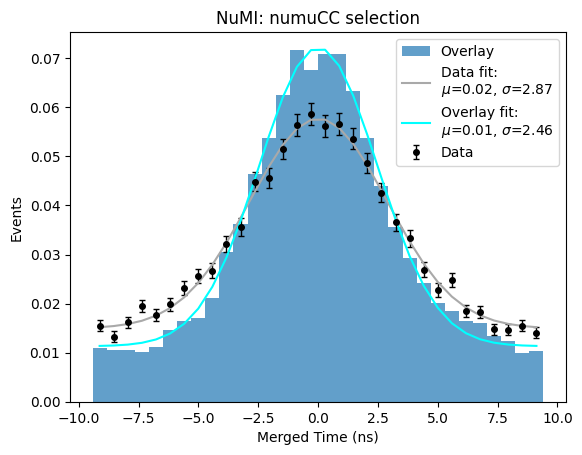

In [16]:
nbins = 32

emulate_ext = True

data = df_numi_data.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["merge_time"].to_numpy()
y,xbins = np.histogram(data,bins=nbins,range=(-9.42, 9.42))

#only using overlay for now, eventually we can move towards a full data to MC comparison that includes EXT and Dirt
overlay = df_numi_mc.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["merge_time"].to_numpy()
#weights = df_numi_mc.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["net_weight"].to_numpy()
weights = np.ones_like(df_numi_mc.query("merge_time>-9.42 and merge_time<9.42 and numu_score>0.9")["merge_time"].to_numpy())
if(emulate_ext):
    ext = np.random.uniform(-9.42, 9.42, size=int(len(overlay)*0.1))
    overlay = np.concatenate((overlay,ext))
weight = np.ones_like(overlay)*len(data)/len(overlay)
y_overlay,xbins = np.histogram(overlay,bins=nbins,range=(-9.42, 9.42),weights=weight)

x = get_bin_centers(xbins)
popt_overlay,pcov = curve_fit(gaus,x,y_overlay/np.sum(y))
print("overlay: Gaussian      mean:",round(popt_overlay[1],4),"  std:",round(popt_overlay[2],4),"  C:",round(popt_overlay[3],4))

popt,pcov = curve_fit(gaus,x,y/np.sum(y))
print("data: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))


plt.figure()
plt.title("NuMI: numuCC selection")
plt.errorbar(get_bin_centers(xbins),y/np.sum(y),yerr=np.sqrt(y)/np.sum(y),ms=8, lw=1,fmt='.',ecolor = 'black',color='black', capsize=2, capthick=1, label="Data")
plt.hist(overlay,bins=nbins,alpha=0.7,range=(-9.42, 9.42),label='Overlay',weights=weight/np.sum(y))
plt.plot(x,gaus(x,*popt),color='darkgray',label='Data fit:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")
plt.plot(x,gaus(x,*popt_overlay),color='cyan',label='Overlay fit:'+'\n'+f"$\mu$={round(popt_overlay[1],2)}, $\sigma$={round(abs(popt_overlay[2]),2)}")
plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
#plt.ylim(0,0.09)
plt.legend()
plt.show()

## Helper functions and varibale definitions for re-calculating the ns time in MC without the calibration

In [17]:

#correction parameters, see here https://github.com/uboone/ubana/blob/develop/ubana/MicroBooNEWireCell/job/run_wcanatree.fcl
f_ccnd1_a = 0.529594 
f_ccnd1_b = 7.13804
f_ccnd2_a = 0.068752
f_ccnd2_b = 2.32023
f_ccnd3_a = 0.4697
f_ccnd3_b = 0.004233
f_ccnd3_c = 0.000001006
f_ccnd3_d = -0.195
f_ccnd4_a = 0
f_ccnd4_b = 0
f_ccnd4_1_a = 0
f_ccnd4_1_b = 0
f_ccnd4_2_a = 0
f_ccnd4_2_b = 0
dist_cut_x_cor = 99999

RWM_offset = 5700


# pmt location
PMT_location = [[-11.4545, -28.625, 990.356], [-11.4175, 27.607, 989.712],
               [-11.7755, -56.514, 951.865], [-11.6415, 55.313, 951.861],
               [-12.0585, -56.309, 911.939], [-11.8345, 55.822, 911.065],
               [-12.1765, -0.722, 865.599], [-12.3045, -0.502, 796.208],
               [-12.6045, -56.284, 751.905], [-12.5405, 55.625, 751.884],
               [-12.6125, -56.408, 711.274], [-12.6615, 55.8, 711.073],
               [-12.6245, -0.051, 664.203], [-12.6515, -0.549, 585.284],
               [-12.8735, 55.822, 540.929], [-12.6205, -56.205, 540.616],
               [-12.5945, -56.323, 500.221], [-12.9835, 55.771, 500.134],
               [-12.6185, -0.875, 453.096], [-13.0855, -0.706, 373.839],
               [-12.6485, -57.022, 328.341], [-13.1865, 54.693, 328.212],
               [-13.4175, 54.646, 287.976], [-13.0075, -56.261, 287.639],
               [-13.1505, -0.829, 242.014], [-13.4415, -0.303, 173.743],
               [-13.3965, 55.249, 128.354], [-13.2784, -56.203, 128.18],
               [-13.2375, -56.615, 87.8695], [-13.5415, 55.249, 87.7605],
               [-13.4345, 27.431, 51.1015], [-13.1525, -28.576, 50.4745]]




#PMT timing ofsets
offset = [1.03002, -5.18104, -2.11164, -5.99395, -1.25798, 0.633079, 2.87666, 2.21969, 0.885092, 2.35423, -1.63039, -1.83775, -0.859883, 3.4741, 1.84833, 1.58233, -2.71783, 0, 3.18776, 0.982666, 0.728438, 0.280592, -5.27068,-3.27857, -1.41196, 1.59643, 1.41425, -1.62682, -2.55772, 1.49136, -0.522791, 0.974533]

sol = 0.033356
sol_Ar = 0.0746


In [18]:
def get_dE_dx(dqdx):
    alpha = 0.93
    beta = 0.212
    dedx = (np.exp((dqdx) * 23.6e-6*beta/1.38/0.273) - alpha)/(beta/1.38/0.273)
    return dedx
    
def get_dE_dx_range(R,pdg):
    if pdg==22 or pdg==11 or pdg==2112: return 0
    A = 8 
    b = -0.37 
    if pdg==2212:    
        A = 17
        b = -0.42
    dedx = A*pow(R,b)
    return dedx

def get_T_range(R,pdg):
    if pdg==22 or pdg==11 or pdg==2112: return 0
    A = 8 
    b = -0.37 
    if pdg==2212:    
        A = 17
        b = -0.42
    T = A/(b+1)*pow(R,b+1)
    return T



In [19]:
# functions needed to utilize PID for more realistic velocities.

def get_time(momentum,startXYZT,endXYZT,pdg,mother_time):
    dx_i = 0.5
    dx = dx_i
    time_position_points = []
    length = np.sqrt( pow(startXYZT[0]-endXYZT[0],2) + pow(startXYZT[1]-endXYZT[1],2) + pow(startXYZT[2]-endXYZT[2],2) )
    residual_range = length
    x_pos = startXYZT[0]
    y_pos = startXYZT[1]
    z_pos = startXYZT[2]            
    mass = 0
    if pdg == 13: mass = 0.1057
    if pdg == 2212: mass = 0.9397933 #Don't do neutrons, KE is not assigned well so just assume c
    if pdg == 211: mass = 0.13982067  
    KE = momentum[3] - mass
    KE_R = momentum[3] - mass
    v_i = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
    if pdg==22 or pdg==2112 or pdg==11: v_i = sol
    v = v_i
    v_R = v_i
    tPh = mother_time
    tPh_R = mother_time
    gamma = 0
    DPh = np.sqrt( pow(startXYZT[0]-x_pos,2) + pow(startXYZT[1]-y_pos,2) + pow(startXYZT[2]-z_pos,2) )
    tPh_alt = DPh*v_i+mother_time
    while residual_range>=0:       
        #save this point
        time_position_points.append([x_pos,y_pos,z_pos,tPh])
        #update for the next point
        if residual_range<dx and dx==dx_i:
            dx = residual_range*1.0000001
        tPh += v*dx 
        dedx = get_dE_dx_range(residual_range,pdg)/1000
        de = dedx*dx #automatically 0 for showers and neutrons, so just useing the "alt" treatment
        KE = KE-de
        v = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
        if pdg==22 or pdg==2112 or pdg==11: v = sol
            
        tPh_R += v_R*dx
        if(pdg==13 or pdg==2212 or abs(pdg)==211): KE_R = get_T_range(residual_range,pdg)/1000
        v_R= np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE_R),2) ),nan=sol)
        if pdg==22 or pdg==2112 or pdg==11: v_R = sol

        gamma+=(dx/length)
        x_pos = startXYZT[0] + gamma*(endXYZT[0]-startXYZT[0])
        y_pos = startXYZT[1] + gamma*(endXYZT[1]-startXYZT[1])
        z_pos = startXYZT[2] + gamma*(endXYZT[2]-startXYZT[2])
        residual_range = length - np.sqrt( pow(startXYZT[0]-x_pos,2) + pow(startXYZT[1]-y_pos,2) + pow(startXYZT[2]-z_pos,2)) 
        DPh = np.sqrt( pow(startXYZT[0]-x_pos,2) + pow(startXYZT[1]-y_pos,2) + pow(startXYZT[2]-z_pos,2) )
        tPh_alt = DPh*v_i+mother_time
    return time_position_points

def set_particle_propegation_times(momentum,startXYZT,endXYZT,ID,pdg,mother):

    dx = 3

    particle_times = {}

    #first round, just do the primary
    for part in range(len(pdg)):
        # Check to see if we already added this particle
        if ID[part] in particle_times: continue  
        # Daughter particles get added after their mother to do the cummulative time right
        if mother[part] != 0: continue

        time_position_points = get_time(momentum[part],startXYZT[part],endXYZT[part],pdg[part],0)       
        particle_times.update({ID[part]:time_position_points})
        
        #check for daughters
        daughters = []
        
        for daught_part in range(len(pdg)): 
            if mother[daught_part] == ID[part]: 
                if len(particle_times[ID[part]])>0: daughters.append([ID[daught_part],daught_part,particle_times[ID[part]][-1][3]])
                else: daughters.append([ID[daught_part],daught_part,0])

        while len(daughters) > 0 :
            this_daughter = daughters[0]
            daughters_id = this_daughter[0]
            #double check we have not already added this particle
            if daughters_id in particle_times: 
                daughters.remove(this_daughter)
                continue 
            daughters_index = this_daughter[1]
            mothers_time = this_daughter[2]
            time_position_points = get_time(momentum[daughters_index],startXYZT[daughters_index],endXYZT[daughters_index],pdg[daughters_index],mothers_time)       
            particle_times.update({daughters_id:time_position_points})  
            #add the daughters of the daughters
            for daught_part in range(len(pdg)): 
                if mother[daught_part] == daughters_id and not(ID[daught_part] in particle_times): 
                    if len(particle_times[daughters_id])>0: daughters.append([ID[daught_part],daught_part,particle_times[daughters_id][-1][3]])
                    else: daughters.append([ID[daught_part],daught_part,0])
            daughters.remove(this_daughter)
            
    return particle_times

## Plot the merged beam peak for the BNB data and new MC
Here, we will recalculate everything, adding both the "linear extrapolation" and the "start and endpoints only" caluculations.

In [20]:
#load in the BNB data
file = uproot.open(bnb_data_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS","run","subrun","event"]+["reco_id","reco_pdg","reco_mother","reco_startMomentum","reco_startXYZT","reco_endXYZT","reco_nuvtxX","reco_nuvtxY","reco_nuvtxZ","RWM_Time","PMT_TimeProp","PMT_Amp","PMT_Time","PMT_ID"]+["reco_sps_x","reco_sps_y","reco_sps_z"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_bnb_new_data = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_bnb_new_data.shape[0])
df_bnb_new_data = df_bnb_new_data.query("evtTimeNS>0")
df_bnb_new_data = df_bnb_new_data.sample(frac=0.1) #if you are impatient, trim the file like this
print(df_bnb_new_data.shape[0])

540998
2853


In [21]:
#load in the new BNB MC
file = uproot.open(bnb_MC_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS","run","subrun","event"]+["reco_id","reco_pdg","reco_mother","reco_startMomentum","reco_startXYZT","reco_endXYZT","reco_nuvtxX","reco_nuvtxY","reco_nuvtxZ","RWM_Time","PMT_TimeProp","PMT_Amp","PMT_Time","PMT_ID",'cor_nu_deltatime']+["reco_sps_x","reco_sps_y","reco_sps_z"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_bnb_new_mc = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_bnb_new_mc.shape[0])
df_bnb_new_mc = df_bnb_new_mc.query("evtTimeNS>0")
df_bnb_new_mc = df_bnb_new_mc.sample(frac=0.1) #if you are impatient, trim the file like this
print(df_bnb_new_mc.shape[0])





93745
3049


In [22]:
# calculate the reconstructed time, this is similar to the code here: https://github.com/uboone/ubana/blob/develop/ubana/MicroBooNEWireCell/WireCellAnaTree_module.cc#L7860
PMT_ID_list =  df_bnb_new_data["PMT_ID"].to_numpy()
PMT_Time_list =  df_bnb_new_data["PMT_Time"].to_numpy()
PMT_Amp_list =  df_bnb_new_data["PMT_Amp"].to_numpy()
RWM_Time_list =  df_bnb_new_data["RWM_Time"].to_numpy()

reco_nuvtxX_list =  df_bnb_new_data["reco_nuvtxX"].to_numpy()
reco_nuvtxY_list =  df_bnb_new_data["reco_nuvtxY"].to_numpy()
reco_nuvtxZ_list =  df_bnb_new_data["reco_nuvtxZ"].to_numpy()
reco_id_list =  df_bnb_new_data["reco_id"].to_numpy()
reco_pdg_list =  df_bnb_new_data["reco_pdg"].to_numpy()
reco_startMomentum_list =  df_bnb_new_data["reco_startMomentum"].to_numpy()
reco_startXYZT_list =  df_bnb_new_data["reco_startXYZT"].to_numpy()
reco_endXYZT_list =  df_bnb_new_data["reco_endXYZT"].to_numpy()
reco_mother_list =  df_bnb_new_data["reco_mother"].to_numpy()

reco_sps_x_list =  df_bnb_new_data["reco_sps_x"].to_numpy()
reco_sps_y_list =  df_bnb_new_data["reco_sps_y"].to_numpy()
reco_sps_z_list =  df_bnb_new_data["reco_sps_z"].to_numpy()



evtTimeNS_endpoints = []
evtTimeNS_endpoints_nocor = []
evtTimeNS_linear = []
evtTimeNS_linear_nocor = []

DLh_endpoints_all = []
DPh_endpoints_all = []
DLh_linear_all = []
DPh_linear_all = []

nu_tof = []

TT3_endpoints_array_all = []
TT3_endpoints_array_nocor_all = []
TT3_linear_array_all = []
TT3_linear_array_nocor_all = []

timeProp_endpoints_all = []
timeProp_linear_all = []


Ph_Tot_all = []

for event in tqdm(range(len(PMT_ID_list))):
   
    PMT_ID = PMT_ID_list[event]
    PMT_Time = PMT_Time_list[event] 
    PMT_Amp = PMT_Amp_list[event]
    RWM_Time = RWM_Time_list[event] 

    reco_nuvtxX = reco_nuvtxX_list[event]
    reco_nuvtxY = reco_nuvtxY_list[event]
    reco_nuvtxZ = reco_nuvtxZ_list[event]
    reco_id = reco_id_list[event]
    reco_pdg = reco_pdg_list[event]
    reco_startMomentum = reco_startMomentum_list[event]
    reco_startXYZT = reco_startXYZT_list[event]
    reco_endXYZT = reco_endXYZT_list[event]
    reco_mother = reco_mother_list[event]
    
    reco_sps_x = reco_sps_x_list[event]
    reco_sps_y = reco_sps_y_list[event]
    reco_sps_z = reco_sps_z_list[event]  
    
    N_PMT = len(PMT_ID)

    #Not enought PMTs above threshold to do the timing
    if(N_PMT<3):
        
        evtTimeNS_endpoints.append(-99999)
        evtTimeNS_endpoints_nocor.append(-99999)
        evtTimeNS_linear.append(-99999)
        evtTimeNS_linear_nocor.append(-99999)
        
        nu_tof.append(-99999)

        DPh_endpoints_all.append([])
        DLh_endpoints_all.append([])
        DPh_linear_all.append([])
        DLh_linear_all.append([])

        TT3_endpoints_array_all.append([])
        TT3_endpoints_array_nocor_all.append([])
        TT3_linear_array_all.append([])
        TT3_linear_array_nocor_all.append([])

        timeProp_endpoints_all.append([])
        timeProp_linear_all.append([])

        Ph_Tot_all.append(-99999)
        
        continue
            
    Ph_Tot = 0
    
    timeProp_endpoints = []
    timeProp_linear = []
    
    TT3_endpoints_array = []
    TT3_endpoints_array_nocor = []    
    TT3_linear_array = []
    TT3_linear_array_nocor = []
    
    ccnd1 = 0
    ccnd2 = 0
    ccnd3 = 0
    ccnd4 = 0

    DPh_endpoints_event = []
    DLh_endpoints_event = []
    DPh_linear_event = []
    DLh_linear_event = []
    
    # For corecting back to the front face of the detector
    dist = reco_nuvtxZ
    nuToF=dist*0.033356;
    nu_tof.append(nuToF)

    particle_times = set_particle_propegation_times(reco_startMomentum,reco_startXYZT,reco_endXYZT,reco_id,reco_pdg,reco_mother)
   
    for pmt in range(N_PMT):

        pmt_id = PMT_ID[pmt]
        
        Ph_Tot=Ph_Tot+PMT_Amp[pmt]

        tp_endpoints=5000000000.0
        tp_linear=5000000000.0
        
        DPh_endpoints_event.append(0)
        DLh_endpoints_event.append(0)        
        DPh_linear_event.append(0)
        DLh_linear_event.append(0)

        # Future goal, can we switch this out for the full set of spacepoints? Can we also incorporate particle velocities?
        for point in range(len(reco_sps_x)):
            DPh_endpoints = np.sqrt( pow(reco_nuvtxX-reco_sps_x[point],2) + pow(reco_nuvtxY-reco_sps_y[point],2) + pow(reco_nuvtxZ-reco_sps_z[point],2) )  
            DLh_endpoints = np.sqrt( pow(PMT_location[pmt_id][0]-reco_sps_x[point],2) + pow(PMT_location[pmt_id][1]-reco_sps_y[point],2) + pow(PMT_location[pmt_id][2]-reco_sps_z[point],2) )
            tPhelp_endpoints = (DPh_endpoints*sol)+(DLh_endpoints*sol_Ar)
            if tPhelp_endpoints<tp_endpoints: 
                tp_endpoints=tPhelp_endpoints
                DPh_endpoints_event[pmt] = DPh_endpoints
                DLh_endpoints_event[pmt] = DLh_endpoints
                
        for part in particle_times:
            particle_time = particle_times[part]
            pdg = 0
            mother = 0
            for i in range(len(reco_id)): 
                if reco_id[i]==part: 
                    pdg = reco_pdg[i]
                    mother = reco_mother[i]

            #Linear extrapolation between start and endpoints, uses particle velocities
            for point in range(len(particle_time)):
                particle_time_point = particle_time[point]
                x_pos = particle_time_point[0]
                y_pos = particle_time_point[1]
                z_pos = particle_time_point[2]
                DLh_linear = np.sqrt( pow(PMT_location[pmt_id][0]-x_pos,2) + pow(PMT_location[pmt_id][1]-y_pos,2) + pow(PMT_location[pmt_id][2]-z_pos,2) )
                DPh_linear = np.sqrt( pow(reco_nuvtxX-x_pos,2) + pow(reco_nuvtxY-y_pos,2) + pow(reco_nuvtxZ-z_pos,2) ) 
                tPhelp_linear = particle_time_point[3]+(DLh_linear*sol_Ar)
                if tPhelp_linear<tp_linear: 
                    tp_linear=tPhelp_linear
                    DPh_linear_event[pmt] = particle_time_point[3]
                    DLh_linear_event[pmt] = DLh_linear
                
        timeProp_endpoints.append(tp_endpoints)  
        timeProp_linear.append(tp_linear)
        
    DPh_endpoints_all.append(DPh_endpoints_event)
    DLh_endpoints_all.append(DLh_endpoints_event)    
    timeProp_endpoints_all.append(timeProp_endpoints) 
    
    DPh_linear_all.append(DPh_linear_event)
    DLh_linear_all.append(DLh_linear_event)    
    timeProp_linear_all.append(timeProp_linear) 
    
    Ph_Tot_all.append(Ph_Tot)
   
    for pmt in range(N_PMT):
        
        pmt_id = PMT_ID[pmt]

        ccnd2 = PMT_Amp[pmt]*(f_ccnd2_a)-(f_ccnd2_b)
        if Ph_Tot>150: ccnd3=f_ccnd3_a-f_ccnd3_b*Ph_Tot+f_ccnd3_c*Ph_Tot*Ph_Tot 
        else: ccnd3=f_ccnd3_d
            
        if reco_nuvtxX<dist_cut_x_cor: ccnd4 = reco_nuvtxX*(f_ccnd4_a)-(f_ccnd4_b)
        else: ccnd4 = reco_nuvtxX*(f_ccnd4_2_a)-(f_ccnd4_2_b)

        ccnd1 = timeProp_endpoints[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_endpoints_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4)
        TT3_endpoints_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] )       

        ccnd1 = timeProp_linear[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_linear_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4 )
        TT3_linear_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] )

    Med_TT3_endpoints = np.median(TT3_endpoints_array)
    evtTimeNS_endpoints.append(Med_TT3_endpoints)
    TT3_endpoints_array_all.append(TT3_endpoints_array)
    
    Med_TT3_endpoints_nocor = np.median(TT3_endpoints_array_nocor)
    evtTimeNS_endpoints_nocor.append(Med_TT3_endpoints_nocor)
    TT3_endpoints_array_nocor_all.append(TT3_endpoints_array_nocor)  

    Med_TT3_linear = np.median(TT3_linear_array)
    evtTimeNS_linear.append(Med_TT3_linear)
    TT3_linear_array_all.append(TT3_linear_array)
    
    Med_TT3_linear_nocor = np.median(TT3_linear_array_nocor)
    evtTimeNS_linear_nocor.append(Med_TT3_linear_nocor)
    TT3_linear_array_nocor_all.append(TT3_linear_array_nocor) 
    

  0%|                                                  | 0/2853 [00:00<?, ?it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:37: RuntimeWarning: invalid value encountered in sqrt
  v = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:18: RuntimeWarning: invalid value encountered in sqrt
  v_i = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
  1%|▎                                        | 22/2853 [00:00<01:54, 24.74it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/3708458504.py:14: RuntimeWarning: divide by zero encountered in scalar power
  dedx = A*pow(R,b)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  de = dedx*dx #automatically 0 for showers and neutrons, so just useing the "alt" treatment
/var/folders/44/h4qhfb4d6r54v8lb5

In [23]:
df_bnb_new_data["evtTimeNS_endpoints"] = evtTimeNS_endpoints
df_bnb_new_data["evtTimeNS_endpoints_nocor"] = evtTimeNS_endpoints_nocor
df_bnb_new_data["evtTimeNS_linear"] = evtTimeNS_linear
df_bnb_new_data["evtTimeNS_linear_nocor"] = evtTimeNS_linear_nocor

df_bnb_new_data["TT3_array_endpoints"] = TT3_endpoints_array_all
df_bnb_new_data["TT3_array_endpoints_nocor"] = TT3_endpoints_array_nocor_all
df_bnb_new_data["TT3_array_linear"] = TT3_linear_array_all
df_bnb_new_data["TT3_array_linear_nocor"] = TT3_linear_array_nocor_all

df_bnb_new_data["timeProp_spacepoints_all"] = timeProp_endpoints_all
df_bnb_new_data["timeProp_linear_all"] = timeProp_linear_all

df_bnb_new_data["nu_tof"] = nu_tof

df_bnb_new_data["DPh_endpoints_all"] = DPh_endpoints_all
df_bnb_new_data["DLh_endpoints_all"] = DLh_endpoints_all
df_bnb_new_data["DPh_linear_all"] = DPh_linear_all
df_bnb_new_data["DLh_linear_all"] = DLh_linear_all

df_bnb_new_data["Ph_Tot"] = Ph_Tot_all

In [24]:
#correction parameters, all zero for the MC
f_ccnd1_a = 0
f_ccnd1_b = 0
f_ccnd2_a = 0
f_ccnd2_b = 0
f_ccnd3_a = 0
f_ccnd3_b = 0
f_ccnd3_c = 0
f_ccnd3_d = 0
f_ccnd4_a = 0
f_ccnd4_b = 0
f_ccnd4_1_a = 0
f_ccnd4_1_b = 0
f_ccnd4_2_a = 0
f_ccnd4_2_b = 0
dist_cut_x_cor = 99999

RWM_offset = 0

#PMT timing ofsets, all zero for the MC
offset = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Switch PMTs for the MC
temp = PMT_location[31]
PMT_location[31] = PMT_location[30]
PMT_location[30] = PMT_location[29]
PMT_location[29] = PMT_location[28]
PMT_location[28] = PMT_location[27]
PMT_location[27] = PMT_location[26]
PMT_location[26] = temp

In [25]:
# calculate the reconstructed time, this is similar to the code here: https://github.com/uboone/ubana/blob/develop/ubana/MicroBooNEWireCell/WireCellAnaTree_module.cc#L7860
PMT_ID_list =  df_bnb_new_mc["PMT_ID"].to_numpy()
PMT_Time_list =  df_bnb_new_mc["PMT_Time"].to_numpy()
PMT_Amp_list =  df_bnb_new_mc["PMT_Amp"].to_numpy()
RWM_Time_list =  df_bnb_new_mc["RWM_Time"].to_numpy()

reco_nuvtxX_list =  df_bnb_new_mc["reco_nuvtxX"].to_numpy()
reco_nuvtxY_list =  df_bnb_new_mc["reco_nuvtxY"].to_numpy()
reco_nuvtxZ_list =  df_bnb_new_mc["reco_nuvtxZ"].to_numpy()
reco_id_list =  df_bnb_new_mc["reco_id"].to_numpy()
reco_pdg_list =  df_bnb_new_mc["reco_pdg"].to_numpy()
reco_startMomentum_list =  df_bnb_new_mc["reco_startMomentum"].to_numpy()
reco_startXYZT_list =  df_bnb_new_mc["reco_startXYZT"].to_numpy()
reco_endXYZT_list =  df_bnb_new_mc["reco_endXYZT"].to_numpy()
reco_mother_list =  df_bnb_new_mc["reco_mother"].to_numpy()

reco_sps_x_list =  df_bnb_new_mc["reco_sps_x"].to_numpy()
reco_sps_y_list =  df_bnb_new_mc["reco_sps_y"].to_numpy()
reco_sps_z_list =  df_bnb_new_mc["reco_sps_z"].to_numpy()


cor_nu_deltatime = df_bnb_new_mc["cor_nu_deltatime"].to_numpy()

evtTimeNS_endpoints = []
evtTimeNS_endpoints_nocor = []
evtTimeNS_linear = []
evtTimeNS_linear_nocor = []

DLh_endpoints_all = []
DPh_endpoints_all = []
DLh_linear_all = []
DPh_linear_all = []

nu_tof = []

TT3_endpoints_array_all = []
TT3_endpoints_array_nocor_all = []
TT3_linear_array_all = []
TT3_linear_array_nocor_all = []

timeProp_endpoints_all = []
timeProp_linear_all = []


Ph_Tot_all = []

for event in tqdm(range(len(PMT_ID_list))):
   
    PMT_ID = PMT_ID_list[event]
    PMT_Time = PMT_Time_list[event] 
    PMT_Amp = PMT_Amp_list[event]
    RWM_Time = RWM_Time_list[event] 

    reco_nuvtxX = reco_nuvtxX_list[event]
    reco_nuvtxY = reco_nuvtxY_list[event]
    reco_nuvtxZ = reco_nuvtxZ_list[event]
    reco_id = reco_id_list[event]
    reco_pdg = reco_pdg_list[event]
    reco_startMomentum = reco_startMomentum_list[event]
    reco_startXYZT = reco_startXYZT_list[event]
    reco_endXYZT = reco_endXYZT_list[event]
    reco_mother = reco_mother_list[event]
    
    reco_sps_x = reco_sps_x_list[event]
    reco_sps_y = reco_sps_y_list[event]
    reco_sps_z = reco_sps_z_list[event]  
    
    N_PMT = len(PMT_ID)

    #Not enought PMTs above threshold to do the timing
    if(N_PMT<3):
        
        evtTimeNS_endpoints.append(-99999)
        evtTimeNS_endpoints_nocor.append(-99999)
        evtTimeNS_linear.append(-99999)
        evtTimeNS_linear_nocor.append(-99999)
        
        nu_tof.append(-99999)

        DPh_endpoints_all.append([])
        DLh_endpoints_all.append([])
        DPh_linear_all.append([])
        DLh_linear_all.append([])

        TT3_endpoints_array_all.append([])
        TT3_endpoints_array_nocor_all.append([])
        TT3_linear_array_all.append([])
        TT3_linear_array_nocor_all.append([])

        timeProp_endpoints_all.append([])
        timeProp_linear_all.append([])

        Ph_Tot_all.append(-99999)
        
        continue
            
    Ph_Tot = 0
    
    timeProp_endpoints = []
    timeProp_linear = []
    
    TT3_endpoints_array = []
    TT3_endpoints_array_nocor = []    
    TT3_linear_array = []
    TT3_linear_array_nocor = []
    
    ccnd1 = 0
    ccnd2 = 0
    ccnd3 = 0
    ccnd4 = 0

    DPh_endpoints_event = []
    DLh_endpoints_event = []
    DPh_linear_event = []
    DLh_linear_event = []
    
    # For corecting back to the front face of the detector
    dist = reco_nuvtxZ
    nuToF=dist*0.033356;
    nu_tof.append(nuToF)

    particle_times = set_particle_propegation_times(reco_startMomentum,reco_startXYZT,reco_endXYZT,reco_id,reco_pdg,reco_mother)
   
    for pmt in range(N_PMT):

        pmt_id = PMT_ID[pmt]
        
        Ph_Tot=Ph_Tot+PMT_Amp[pmt]

        tp_endpoints=5000000000.0
        tp_linear=5000000000.0
        
        DPh_endpoints_event.append(0)
        DLh_endpoints_event.append(0)        
        DPh_linear_event.append(0)
        DLh_linear_event.append(0)

        # Future goal, can we switch this out for the full set of spacepoints? Can we also incorporate particle velocities?
        for point in range(len(reco_sps_x)):
            DPh_endpoints = np.sqrt( pow(reco_nuvtxX-reco_sps_x[point],2) + pow(reco_nuvtxY-reco_sps_y[point],2) + pow(reco_nuvtxZ-reco_sps_z[point],2) )  
            DLh_endpoints = np.sqrt( pow(PMT_location[pmt_id][0]-reco_sps_x[point],2) + pow(PMT_location[pmt_id][1]-reco_sps_y[point],2) + pow(PMT_location[pmt_id][2]-reco_sps_z[point],2) )
            tPhelp_endpoints = (DPh_endpoints*sol)+(DLh_endpoints*sol_Ar)
            if tPhelp_endpoints<tp_endpoints: 
                tp_endpoints=tPhelp_endpoints
                DPh_endpoints_event[pmt] = DPh_endpoints
                DLh_endpoints_event[pmt] = DLh_endpoints
                
        for part in particle_times:
            particle_time = particle_times[part]
            pdg = 0
            mother = 0
            for i in range(len(reco_id)): 
                if reco_id[i]==part: 
                    pdg = reco_pdg[i]
                    mother = reco_mother[i]

            #Linear extrapolation between start and endpoints, uses particle velocities
            for point in range(len(particle_time)):
                particle_time_point = particle_time[point]
                x_pos = particle_time_point[0]
                y_pos = particle_time_point[1]
                z_pos = particle_time_point[2]
                DLh_linear = np.sqrt( pow(PMT_location[pmt_id][0]-x_pos,2) + pow(PMT_location[pmt_id][1]-y_pos,2) + pow(PMT_location[pmt_id][2]-z_pos,2) )
                DPh_linear = np.sqrt( pow(reco_nuvtxX-x_pos,2) + pow(reco_nuvtxY-y_pos,2) + pow(reco_nuvtxZ-z_pos,2) ) 
                tPhelp_linear = particle_time_point[3]+(DLh_linear*sol_Ar)
                if tPhelp_linear<tp_linear: 
                    tp_linear=tPhelp_linear
                    DPh_linear_event[pmt] = particle_time_point[3]
                    DLh_linear_event[pmt] = DLh_linear
                
        timeProp_endpoints.append(tp_endpoints)  
        timeProp_linear.append(tp_linear)
        
    DPh_endpoints_all.append(DPh_endpoints_event)
    DLh_endpoints_all.append(DLh_endpoints_event)    
    timeProp_endpoints_all.append(timeProp_endpoints) 
    
    DPh_linear_all.append(DPh_linear_event)
    DLh_linear_all.append(DLh_linear_event)    
    timeProp_linear_all.append(timeProp_linear) 
    
    Ph_Tot_all.append(Ph_Tot)
   
    for pmt in range(N_PMT):
        
        pmt_id = PMT_ID[pmt]

        ccnd2 = PMT_Amp[pmt]*(f_ccnd2_a)-(f_ccnd2_b)
        if Ph_Tot>150: ccnd3=f_ccnd3_a-f_ccnd3_b*Ph_Tot+f_ccnd3_c*Ph_Tot*Ph_Tot 
        else: ccnd3=f_ccnd3_d
            
        if reco_nuvtxX<dist_cut_x_cor: ccnd4 = reco_nuvtxX*(f_ccnd4_a)-(f_ccnd4_b)
        else: ccnd4 = reco_nuvtxX*(f_ccnd4_2_a)-(f_ccnd4_2_b)

        ccnd1 = timeProp_endpoints[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_endpoints_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4 +cor_nu_deltatime[event])
        TT3_endpoints_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] +cor_nu_deltatime[event])       

        ccnd1 = timeProp_linear[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_linear_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4 +cor_nu_deltatime[event])
        TT3_linear_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] +cor_nu_deltatime[event])

    Med_TT3_endpoints = np.median(TT3_endpoints_array)
    evtTimeNS_endpoints.append(Med_TT3_endpoints)
    TT3_endpoints_array_all.append(TT3_endpoints_array)
    
    Med_TT3_endpoints_nocor = np.median(TT3_endpoints_array_nocor)
    evtTimeNS_endpoints_nocor.append(Med_TT3_endpoints_nocor)
    TT3_endpoints_array_nocor_all.append(TT3_endpoints_array_nocor)  

    Med_TT3_linear = np.median(TT3_linear_array)
    evtTimeNS_linear.append(Med_TT3_linear)
    TT3_linear_array_all.append(TT3_linear_array)
    
    Med_TT3_linear_nocor = np.median(TT3_linear_array_nocor)
    evtTimeNS_linear_nocor.append(Med_TT3_linear_nocor)
    TT3_linear_array_nocor_all.append(TT3_linear_array_nocor) 
    

  0%|                                                  | 0/3049 [00:00<?, ?it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/3708458504.py:14: RuntimeWarning: divide by zero encountered in scalar power
  dedx = A*pow(R,b)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  de = dedx*dx #automatically 0 for showers and neutrons, so just useing the "alt" treatment
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:45: RuntimeWarning: invalid value encountered in scalar divide
  gamma+=(dx/length)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:37: RuntimeWarning: invalid value encountered in sqrt
  v = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
  0%|                                          | 2/3049 [00:00<02:38, 19.21it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349

In [26]:
df_bnb_new_mc["evtTimeNS_endpoints"] = evtTimeNS_endpoints
df_bnb_new_mc["evtTimeNS_endpoints_nocor"] = evtTimeNS_endpoints_nocor
df_bnb_new_mc["evtTimeNS_linear"] = evtTimeNS_linear
df_bnb_new_mc["evtTimeNS_linear_nocor"] = evtTimeNS_linear_nocor

df_bnb_new_mc["TT3_array_endpoints"] = TT3_endpoints_array_all
df_bnb_new_mc["TT3_array_endpoints_nocor"] = TT3_endpoints_array_nocor_all
df_bnb_new_mc["TT3_array_linear"] = TT3_linear_array_all
df_bnb_new_mc["TT3_array_linear_nocor"] = TT3_linear_array_nocor_all

df_bnb_new_mc["timeProp_spacepoints_all"] = timeProp_endpoints_all
df_bnb_new_mc["timeProp_linear_all"] = timeProp_linear_all

df_bnb_new_mc["nu_tof"] = nu_tof

df_bnb_new_mc["DPh_endpoints_all"] = DPh_endpoints_all
df_bnb_new_mc["DLh_endpoints_all"] = DLh_endpoints_all
df_bnb_new_mc["DPh_linear_all"] = DPh_linear_all
df_bnb_new_mc["DLh_linear_all"] = DLh_linear_all

df_bnb_new_mc["Ph_Tot"] = Ph_Tot_all

In [27]:
#merge everything into a single peak with the run dependent corrections
#you may have to play around with Shift to get things aligned at 0
run = df_bnb_new_data["run"].to_numpy()
evtTimeNS = np.nan_to_num(df_bnb_new_data["evtTimeNS_linear"].to_numpy(),nan=-999999,posinf=-999999,neginf=-999999)
print(evtTimeNS)
new_times = []

for i in range(len(evtTimeNS)):
    
    gap=bnb_gap
    Shift=0
    TThelp=0
    if (run[i] >= 19500): Shift=2920.5-0.2+4.8
    elif (run[i] >= 17380): Shift=2916.0 
    elif (run[i] >= 13697): Shift = 3147.3
    elif (run[i] >= 10812): Shift = 3568.5 
    elif (run[i] >= 8321): Shift = 3610.7
    elif (run[i] >= 5800): Shift = 3164.4
    elif (run[i] > 0 ): Shift = 3168.9
    TThelp = evtTimeNS[i]-Shift+gap*0.5
    TT_merged = -9999.

    if(TThelp>=0): 
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_bnb_new_data["merge_time_linear"] = new_times

[4234.78932721 4286.41050372 3934.16350608 ... 3803.5208426  3681.48715954
 4286.33501483]


In [28]:
#merge everything into a single peak
#you may have to play around with Shift to get things aligned at 0
evtTimeNS = df_bnb_new_mc["evtTimeNS_linear"].to_numpy()
new_times = []

for i in range(len(evtTimeNS)):

    if np.nan_to_num(evtTimeNS[i],nan=-999999,posinf=-999999,neginf=-999999)<=0:
        new_times.append(-9999)
        continue

    gap = bnb_gap
    Shift=5.2
    TThelp=0

    TThelp = evtTimeNS[i]-Shift+gap*0.5
    TT_merged = -9999.

    TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_bnb_new_mc["merge_time_linear"] = new_times

overlay: Gaussian      mean: -0.0063   std: 2.5597   C: 0.0035
data: Gaussian      mean: -0.0767   std: 2.8635   C: 0.0041


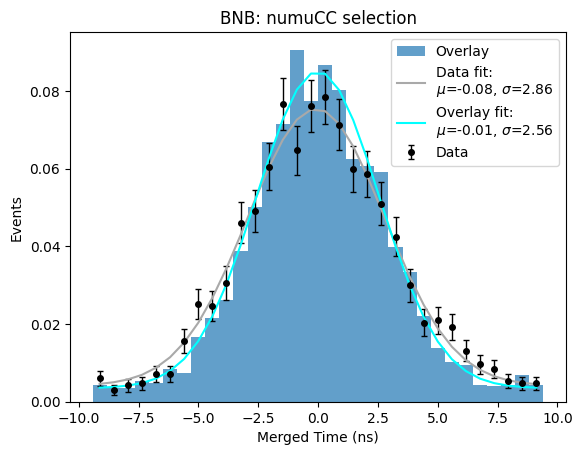

In [29]:
nbins = 32

emulate_ext = True

data = df_bnb_new_data.query("merge_time_linear>-9.42 and merge_time_linear<9.42 and numu_score>0.9")["merge_time_linear"].to_numpy()
y,xbins = np.histogram(data,bins=nbins,range=(-9.42, 9.42))

#only using overlay for now, eventually we can move towards a full data to MC comparison that includes EXT and Dirt
overlay = df_bnb_new_mc.query("merge_time_linear>-9.42 and merge_time_linear<9.42 and numu_score>0.9")["merge_time_linear"].to_numpy()
weights = np.ones_like(df_bnb_new_mc.query("merge_time_linear>-9.42 and merge_time_linear<9.42 and numu_score>0.9")["merge_time_linear"].to_numpy())
if(emulate_ext):
    ext = np.random.uniform(-9.42, 9.42, size=int(len(overlay)*0.03))
    overlay = np.concatenate((overlay,ext))
weight = np.ones_like(overlay)*len(data)/len(overlay)
y_overlay,xbins = np.histogram(overlay,bins=nbins,range=(-9.42, 9.42),weights=weight)

x = get_bin_centers(xbins)

popt_overlay,pcov = curve_fit(gaus,x,y_overlay/np.sum(y))
print("overlay: Gaussian      mean:",round(popt_overlay[1],4),"  std:",round(popt_overlay[2],4),"  C:",round(popt_overlay[3],4))

popt,pcov = curve_fit(gaus,x,y/np.sum(y))
print("data: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))


plt.figure()
plt.title("BNB: numuCC selection")
plt.errorbar(get_bin_centers(xbins),y/np.sum(y),yerr=np.sqrt(y)/np.sum(y),ms=8, lw=1,fmt='.',ecolor = 'black',color='black', capsize=2, capthick=1, label="Data")
plt.hist(overlay,bins=nbins,alpha=0.7,range=(-9.42, 9.42),label='Overlay',weights=weight/np.sum(y))
plt.plot(x,gaus(x,*popt),color='darkgray',label='Data fit:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")
plt.plot(x,gaus(x,*popt_overlay),color='cyan',label='Overlay fit:'+'\n'+f"$\mu$={round(popt_overlay[1],2)}, $\sigma$={round(abs(popt_overlay[2]),2)}")
plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.legend()
plt.show()

In [30]:
#comparison of the "linear extrapolation" and the "start and endpoints only"?

## Plot the merged beam peak for the NuMI data and new MC
Here, we will recalculate everything, adding both the "linear extrapolation" and the "start and endpoints only" caluculations.

In [31]:
#z plane location for the numi nutof correction
target_dir = [-0.46, -0.05, -0.885]
min_a = -122.86902944472968
min_b = 80.60659897339974
min_c = 59.34119182916038

In [32]:
#load in the NuMI data
file = uproot.open(numi_data_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS","run","subrun","event"]+["reco_id","reco_pdg","reco_mother","reco_startMomentum","reco_startXYZT","reco_endXYZT","reco_nuvtxX","reco_nuvtxY","reco_nuvtxZ","RWM_Time","PMT_TimeProp","PMT_Amp","PMT_Time","PMT_ID"]+["reco_sps_x","reco_sps_y","reco_sps_z"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_numi_new_data = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_numi_new_data.shape[0])
df_numi_new_data = df_numi_new_data.query("evtTimeNS>0")
df_numi_new_data = df_numi_new_data.sample(frac=0.2) #if you are impatient, trim the file like this
print(df_numi_new_data.shape[0])

559630
5282


In [33]:
#load in the new NuMI MC
file = uproot.open(numi_MC_filename)
pfeval_df = file["wcpselection"]["T_PFeval"].pandas.df(["evtTimeNS","run","subrun","event"]+["reco_id","reco_pdg","reco_mother","reco_startMomentum","reco_startXYZT","reco_endXYZT","reco_nuvtxX","reco_nuvtxY","reco_nuvtxZ","RWM_Time","PMT_TimeProp","PMT_Amp","PMT_Time","PMT_ID",'cor_nu_deltatime']+["reco_sps_x","reco_sps_y","reco_sps_z"], flatten=False)
bdt_df = file["wcpselection"]["T_BDTvars"].pandas.df(["numu_score"], flatten=False)
df_numi_new_mc = pd.concat([pfeval_df,bdt_df], axis=1, sort=False)
del pfeval_df
del bdt_df
print(df_numi_new_mc.shape[0])
df_numi_new_mc = df_numi_new_mc.query("evtTimeNS>0")
df_numi_new_mc = df_numi_new_mc.sample(frac=0.2) #if you are impatient, trim the file like this
print(df_numi_new_mc.shape[0])




42806
2674


In [34]:


#correction parameters, see here https://github.com/uboone/ubana/blob/develop/ubana/MicroBooNEWireCell/utils/def_filetype.sh
f_ccnd1_a = 0.4343
f_ccnd1_b = 6.2884
f_ccnd2_a = 0.0637
f_ccnd2_b = 1.489
f_ccnd3_a = 0
f_ccnd3_b = 0
f_ccnd3_c = 0
f_ccnd3_d = 0
f_ccnd4_a = 0.0125
f_ccnd4_b = 2.3152
f_ccnd4_1_a = 0
f_ccnd4_1_b = 0
f_ccnd4_2_a = 0
f_ccnd4_2_b = 0
dist_cut_x_cor = 99999

RWM_offset = 5700


# pmt location
PMT_location = [[-11.4545, -28.625, 990.356], [-11.4175, 27.607, 989.712],
               [-11.7755, -56.514, 951.865], [-11.6415, 55.313, 951.861],
               [-12.0585, -56.309, 911.939], [-11.8345, 55.822, 911.065],
               [-12.1765, -0.722, 865.599], [-12.3045, -0.502, 796.208],
               [-12.6045, -56.284, 751.905], [-12.5405, 55.625, 751.884],
               [-12.6125, -56.408, 711.274], [-12.6615, 55.8, 711.073],
               [-12.6245, -0.051, 664.203], [-12.6515, -0.549, 585.284],
               [-12.8735, 55.822, 540.929], [-12.6205, -56.205, 540.616],
               [-12.5945, -56.323, 500.221], [-12.9835, 55.771, 500.134],
               [-12.6185, -0.875, 453.096], [-13.0855, -0.706, 373.839],
               [-12.6485, -57.022, 328.341], [-13.1865, 54.693, 328.212],
               [-13.4175, 54.646, 287.976], [-13.0075, -56.261, 287.639],
               [-13.1505, -0.829, 242.014], [-13.4415, -0.303, 173.743],
               [-13.3965, 55.249, 128.354], [-13.2784, -56.203, 128.18],
               [-13.2375, -56.615, 87.8695], [-13.5415, 55.249, 87.7605],
               [-13.4345, 27.431, 51.1015], [-13.1525, -28.576, 50.4745]]




#PMT timing ofsets
offset = [1.03002, -5.18104, -2.11164, -5.99395, -1.25798, 0.633079, 2.87666, 2.21969, 0.885092, 2.35423, -1.63039, -1.83775, -0.859883, 3.4741, 1.84833, 1.58233, -2.71783, 0, 3.18776, 0.982666, 0.728438, 0.280592, -5.27068,-3.27857, -1.41196, 1.59643, 1.41425, -1.62682, -2.55772, 1.49136, -0.522791, 0.974533]

sol = 0.033356
sol_Ar = 0.0746


In [35]:
# calculate the reconstructed time, this is similar to the code here: https://github.com/uboone/ubana/blob/develop/ubana/MicroBooNEWireCell/WireCellAnaTree_module.cc#L7860
PMT_ID_list =  df_numi_new_data["PMT_ID"].to_numpy()
PMT_Time_list =  df_numi_new_data["PMT_Time"].to_numpy()
PMT_Amp_list =  df_numi_new_data["PMT_Amp"].to_numpy()
RWM_Time_list =  df_numi_new_data["RWM_Time"].to_numpy()

reco_nuvtxX_list =  df_numi_new_data["reco_nuvtxX"].to_numpy()
reco_nuvtxY_list =  df_numi_new_data["reco_nuvtxY"].to_numpy()
reco_nuvtxZ_list =  df_numi_new_data["reco_nuvtxZ"].to_numpy()
reco_id_list =  df_numi_new_data["reco_id"].to_numpy()
reco_pdg_list =  df_numi_new_data["reco_pdg"].to_numpy()
reco_startMomentum_list =  df_numi_new_data["reco_startMomentum"].to_numpy()
reco_startXYZT_list =  df_numi_new_data["reco_startXYZT"].to_numpy()
reco_endXYZT_list =  df_numi_new_data["reco_endXYZT"].to_numpy()
reco_mother_list =  df_numi_new_data["reco_mother"].to_numpy()

reco_sps_x_list =  df_numi_new_data["reco_sps_x"].to_numpy()
reco_sps_y_list =  df_numi_new_data["reco_sps_y"].to_numpy()
reco_sps_z_list =  df_numi_new_data["reco_sps_z"].to_numpy()

evtTimeNS_endpoints = []
evtTimeNS_endpoints_nocor = []
evtTimeNS_linear = []
evtTimeNS_linear_nocor = []

DLh_endpoints_all = []
DPh_endpoints_all = []
DLh_linear_all = []
DPh_linear_all = []

nu_tof = []

TT3_endpoints_array_all = []
TT3_endpoints_array_nocor_all = []
TT3_linear_array_all = []
TT3_linear_array_nocor_all = []

timeProp_endpoints_all = []
timeProp_linear_all = []


Ph_Tot_all = []

for event in tqdm(range(len(PMT_ID_list))):
   
    PMT_ID = PMT_ID_list[event]
    PMT_Time = PMT_Time_list[event] 
    PMT_Amp = PMT_Amp_list[event]
    RWM_Time = RWM_Time_list[event] 

    reco_nuvtxX = reco_nuvtxX_list[event]
    reco_nuvtxY = reco_nuvtxY_list[event]
    reco_nuvtxZ = reco_nuvtxZ_list[event]
    reco_id = reco_id_list[event]
    reco_pdg = reco_pdg_list[event]
    reco_startMomentum = reco_startMomentum_list[event]
    reco_startXYZT = reco_startXYZT_list[event]
    reco_endXYZT = reco_endXYZT_list[event]
    reco_mother = reco_mother_list[event]
    
    reco_sps_x = reco_sps_x_list[event]
    reco_sps_y = reco_sps_y_list[event]
    reco_sps_z = reco_sps_z_list[event]  
    
    N_PMT = len(PMT_ID)

    #Not enought PMTs above threshold to do the timing
    if(N_PMT<3):
        
        evtTimeNS_endpoints.append(-99999)
        evtTimeNS_endpoints_nocor.append(-99999)
        evtTimeNS_linear.append(-99999)
        evtTimeNS_linear_nocor.append(-99999)
        
        nu_tof.append(-99999)

        DPh_endpoints_all.append([])
        DLh_endpoints_all.append([])
        DPh_linear_all.append([])
        DLh_linear_all.append([])

        TT3_endpoints_array_all.append([])
        TT3_endpoints_array_nocor_all.append([])
        TT3_linear_array_all.append([])
        TT3_linear_array_nocor_all.append([])

        timeProp_endpoints_all.append([])
        timeProp_linear_all.append([])

        Ph_Tot_all.append(-99999)
        
        continue
            
    Ph_Tot = 0
    
    timeProp_endpoints = []
    timeProp_linear = []
    
    TT3_endpoints_array = []
    TT3_endpoints_array_nocor = []    
    TT3_linear_array = []
    TT3_linear_array_nocor = []
    
    ccnd1 = 0
    ccnd2 = 0
    ccnd3 = 0
    ccnd4 = 0

    DPh_endpoints_event = []
    DLh_endpoints_event = []
    DPh_linear_event = []
    DLh_linear_event = []
    
    # For numi, we correct back to a plane close to the from face of the detector that is perpendicular to the beam direction.
    dist = ( (min_a-reco_nuvtxX)*target_dir[0] + (min_b-reco_nuvtxY)*target_dir[1] + (min_c-reco_nuvtxZ)*target_dir[2] ) / np.sqrt(target_dir[0]*target_dir[0] + target_dir[1]*target_dir[1] + target_dir[2]*target_dir[2] )
    nuToF=dist*0.033356;
    nu_tof.append(nuToF)

    particle_times = set_particle_propegation_times(reco_startMomentum,reco_startXYZT,reco_endXYZT,reco_id,reco_pdg,reco_mother)
   
    for pmt in range(N_PMT):

        pmt_id = PMT_ID[pmt]
        
        Ph_Tot=Ph_Tot+PMT_Amp[pmt]

        tp_endpoints=5000000000.0
        tp_linear=5000000000.0
        
        DPh_endpoints_event.append(0)
        DLh_endpoints_event.append(0)        
        DPh_linear_event.append(0)
        DLh_linear_event.append(0)

        # Future goal, can we switch this out for the full set of spacepoints? Can we also incorporate particle velocities?
        for point in range(len(reco_sps_x)):
            DPh_endpoints = np.sqrt( pow(reco_nuvtxX-reco_sps_x[point],2) + pow(reco_nuvtxY-reco_sps_y[point],2) + pow(reco_nuvtxZ-reco_sps_z[point],2) )  
            DLh_endpoints = np.sqrt( pow(PMT_location[pmt_id][0]-reco_sps_x[point],2) + pow(PMT_location[pmt_id][1]-reco_sps_y[point],2) + pow(PMT_location[pmt_id][2]-reco_sps_z[point],2) )
            tPhelp_endpoints = (DPh_endpoints*sol)+(DLh_endpoints*sol_Ar)
            if tPhelp_endpoints<tp_endpoints: 
                tp_endpoints=tPhelp_endpoints
                DPh_endpoints_event[pmt] = DPh_endpoints
                DLh_endpoints_event[pmt] = DLh_endpoints
                
        for part in particle_times:
            particle_time = particle_times[part]
            pdg = 0
            mother = 0
            for i in range(len(reco_id)): 
                if reco_id[i]==part: 
                    pdg = reco_pdg[i]
                    mother = reco_mother[i]

            #Linear extrapolation between start and endpoints, uses particle velocities
            for point in range(len(particle_time)):
                particle_time_point = particle_time[point]
                x_pos = particle_time_point[0]
                y_pos = particle_time_point[1]
                z_pos = particle_time_point[2]
                DLh_linear = np.sqrt( pow(PMT_location[pmt_id][0]-x_pos,2) + pow(PMT_location[pmt_id][1]-y_pos,2) + pow(PMT_location[pmt_id][2]-z_pos,2) )
                DPh_linear = np.sqrt( pow(reco_nuvtxX-x_pos,2) + pow(reco_nuvtxY-y_pos,2) + pow(reco_nuvtxZ-z_pos,2) ) 
                tPhelp_linear = particle_time_point[3]+(DLh_linear*sol_Ar)
                if tPhelp_linear<tp_linear: 
                    tp_linear=tPhelp_linear
                    DPh_linear_event[pmt] = particle_time_point[3]
                    DLh_linear_event[pmt] = DLh_linear
                
        timeProp_endpoints.append(tp_endpoints)  
        timeProp_linear.append(tp_linear)
        
    DPh_endpoints_all.append(DPh_endpoints_event)
    DLh_endpoints_all.append(DLh_endpoints_event)    
    timeProp_endpoints_all.append(timeProp_endpoints) 
    
    DPh_linear_all.append(DPh_linear_event)
    DLh_linear_all.append(DLh_linear_event)    
    timeProp_linear_all.append(timeProp_linear) 
    
    Ph_Tot_all.append(Ph_Tot)
   
    for pmt in range(N_PMT):
        
        pmt_id = PMT_ID[pmt]

        ccnd2 = PMT_Amp[pmt]*(f_ccnd2_a)-(f_ccnd2_b)
        if Ph_Tot>150: ccnd3=f_ccnd3_a-f_ccnd3_b*Ph_Tot+f_ccnd3_c*Ph_Tot*Ph_Tot 
        else: ccnd3=f_ccnd3_d
            
        if reco_nuvtxX<dist_cut_x_cor: ccnd4 = reco_nuvtxX*(f_ccnd4_a)-(f_ccnd4_b)
        else: ccnd4 = reco_nuvtxX*(f_ccnd4_2_a)-(f_ccnd4_2_b)

        ccnd1 = timeProp_endpoints[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_endpoints_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4 )
        TT3_endpoints_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] )       

        ccnd1 = timeProp_linear[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_linear_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4 )
        TT3_linear_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] )

    Med_TT3_endpoints = np.median(TT3_endpoints_array)
    evtTimeNS_endpoints.append(Med_TT3_endpoints)
    TT3_endpoints_array_all.append(TT3_endpoints_array)
    
    Med_TT3_endpoints_nocor = np.median(TT3_endpoints_array_nocor)
    evtTimeNS_endpoints_nocor.append(Med_TT3_endpoints_nocor)
    TT3_endpoints_array_nocor_all.append(TT3_endpoints_array_nocor)  

    Med_TT3_linear = np.median(TT3_linear_array)
    evtTimeNS_linear.append(Med_TT3_linear)
    TT3_linear_array_all.append(TT3_linear_array)
    
    Med_TT3_linear_nocor = np.median(TT3_linear_array_nocor)
    evtTimeNS_linear_nocor.append(Med_TT3_linear_nocor)
    TT3_linear_array_nocor_all.append(TT3_linear_array_nocor) 
    

  0%|                                                  | 0/5282 [00:00<?, ?it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:37: RuntimeWarning: invalid value encountered in sqrt
  v = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:18: RuntimeWarning: invalid value encountered in sqrt
  v_i = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/3708458504.py:14: RuntimeWarning: divide by zero encountered in scalar power
  dedx = A*pow(R,b)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  de = dedx*dx #automatically 0 for showers and neutrons, so just useing the "alt" treatment
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:45: RuntimeWarning: invalid value 

In [36]:
df_numi_new_data["evtTimeNS_endpoints"] = evtTimeNS_endpoints
df_numi_new_data["evtTimeNS_endpoints_nocor"] = evtTimeNS_endpoints_nocor
df_numi_new_data["evtTimeNS_linear"] = evtTimeNS_linear
df_numi_new_data["evtTimeNS_linear_nocor"] = evtTimeNS_linear_nocor

df_numi_new_data["TT3_array_endpoints"] = TT3_endpoints_array_all
df_numi_new_data["TT3_array_endpoints_nocor"] = TT3_endpoints_array_nocor_all
df_numi_new_data["TT3_array_linear"] = TT3_linear_array_all
df_numi_new_data["TT3_array_linear_nocor"] = TT3_linear_array_nocor_all

df_numi_new_data["timeProp_spacepoints_all"] = timeProp_endpoints_all
df_numi_new_data["timeProp_linear_all"] = timeProp_linear_all

df_numi_new_data["nu_tof"] = nu_tof

df_numi_new_data["DPh_endpoints_all"] = DPh_endpoints_all
df_numi_new_data["DLh_endpoints_all"] = DLh_endpoints_all
df_numi_new_data["DPh_linear_all"] = DPh_linear_all
df_numi_new_data["DLh_linear_all"] = DLh_linear_all

df_numi_new_data["Ph_Tot"] = Ph_Tot_all

In [37]:
#correction parameters, all zero for the MC
f_ccnd1_a = 0
f_ccnd1_b = 0
f_ccnd2_a = 0
f_ccnd2_b = 0
f_ccnd3_a = 0
f_ccnd3_b = 0
f_ccnd3_c = 0
f_ccnd3_d = 0
f_ccnd4_a = 0
f_ccnd4_b = 0
f_ccnd4_1_a = 0
f_ccnd4_1_b = 0
f_ccnd4_2_a = 0
f_ccnd4_2_b = 0
dist_cut_x_cor = 99999

RWM_offset = 0

#PMT timing ofsets, all zero for the MC
offset = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Switch PMTs for the MC
temp = PMT_location[31]
PMT_location[31] = PMT_location[30]
PMT_location[30] = PMT_location[29]
PMT_location[29] = PMT_location[28]
PMT_location[28] = PMT_location[27]
PMT_location[27] = PMT_location[26]
PMT_location[26] = temp

In [38]:
# calculate the reconstructed time, this is similar to the code here: https://github.com/uboone/ubana/blob/develop/ubana/MicroBooNEWireCell/WireCellAnaTree_module.cc#L7860
PMT_ID_list =  df_numi_new_mc["PMT_ID"].to_numpy()
PMT_Time_list =  df_numi_new_mc["PMT_Time"].to_numpy()
PMT_Amp_list =  df_numi_new_mc["PMT_Amp"].to_numpy()
RWM_Time_list =  df_numi_new_mc["RWM_Time"].to_numpy()

reco_nuvtxX_list =  df_numi_new_mc["reco_nuvtxX"].to_numpy()
reco_nuvtxY_list =  df_numi_new_mc["reco_nuvtxY"].to_numpy()
reco_nuvtxZ_list =  df_numi_new_mc["reco_nuvtxZ"].to_numpy()
reco_id_list =  df_numi_new_mc["reco_id"].to_numpy()
reco_pdg_list =  df_numi_new_mc["reco_pdg"].to_numpy()
reco_startMomentum_list =  df_numi_new_mc["reco_startMomentum"].to_numpy()
reco_startXYZT_list =  df_numi_new_mc["reco_startXYZT"].to_numpy()
reco_endXYZT_list =  df_numi_new_mc["reco_endXYZT"].to_numpy()
reco_mother_list =  df_numi_new_mc["reco_mother"].to_numpy()

reco_sps_x_list =  df_numi_new_mc["reco_sps_x"].to_numpy()
reco_sps_y_list =  df_numi_new_mc["reco_sps_y"].to_numpy()
reco_sps_z_list =  df_numi_new_mc["reco_sps_z"].to_numpy()


cor_nu_deltatime = df_numi_new_mc["cor_nu_deltatime"].to_numpy()

evtTimeNS_endpoints = []
evtTimeNS_endpoints_nocor = []
evtTimeNS_linear = []
evtTimeNS_linear_nocor = []

DLh_endpoints_all = []
DPh_endpoints_all = []
DLh_linear_all = []
DPh_linear_all = []

nu_tof = []

TT3_endpoints_array_all = []
TT3_endpoints_array_nocor_all = []
TT3_linear_array_all = []
TT3_linear_array_nocor_all = []

timeProp_endpoints_all = []
timeProp_linear_all = []


Ph_Tot_all = []

for event in tqdm(range(len(PMT_ID_list))):
   
    PMT_ID = PMT_ID_list[event]
    PMT_Time = PMT_Time_list[event] 
    PMT_Amp = PMT_Amp_list[event]
    RWM_Time = RWM_Time_list[event] 

    reco_nuvtxX = reco_nuvtxX_list[event]
    reco_nuvtxY = reco_nuvtxY_list[event]
    reco_nuvtxZ = reco_nuvtxZ_list[event]
    reco_id = reco_id_list[event]
    reco_pdg = reco_pdg_list[event]
    reco_startMomentum = reco_startMomentum_list[event]
    reco_startXYZT = reco_startXYZT_list[event]
    reco_endXYZT = reco_endXYZT_list[event]
    reco_mother = reco_mother_list[event]
    
    reco_sps_x = reco_sps_x_list[event]
    reco_sps_y = reco_sps_y_list[event]
    reco_sps_z = reco_sps_z_list[event]  
    
    N_PMT = len(PMT_ID)

    #Not enought PMTs above threshold to do the timing
    if(N_PMT<3):
        
        evtTimeNS_endpoints.append(-99999)
        evtTimeNS_endpoints_nocor.append(-99999)
        evtTimeNS_linear.append(-99999)
        evtTimeNS_linear_nocor.append(-99999)
        
        nu_tof.append(-99999)

        DPh_endpoints_all.append([])
        DLh_endpoints_all.append([])
        DPh_linear_all.append([])
        DLh_linear_all.append([])

        TT3_endpoints_array_all.append([])
        TT3_endpoints_array_nocor_all.append([])
        TT3_linear_array_all.append([])
        TT3_linear_array_nocor_all.append([])

        timeProp_endpoints_all.append([])
        timeProp_linear_all.append([])

        Ph_Tot_all.append(-99999)
        
        continue
            
    Ph_Tot = 0
    
    timeProp_endpoints = []
    timeProp_linear = []
    
    TT3_endpoints_array = []
    TT3_endpoints_array_nocor = []    
    TT3_linear_array = []
    TT3_linear_array_nocor = []
    
    ccnd1 = 0
    ccnd2 = 0
    ccnd3 = 0
    ccnd4 = 0

    DPh_endpoints_event = []
    DLh_endpoints_event = []
    DPh_linear_event = []
    DLh_linear_event = []
    
    # For numi, we correct back to a plane close to the from face of the detector that is perpendicular to the beam direction.
    dist = ( (min_a-reco_nuvtxX)*target_dir[0] + (min_b-reco_nuvtxY)*target_dir[1] + (min_c-reco_nuvtxZ)*target_dir[2] ) / np.sqrt(target_dir[0]*target_dir[0] + target_dir[1]*target_dir[1] + target_dir[2]*target_dir[2] )
    nuToF=dist*0.033356;
    nu_tof.append(nuToF)

    particle_times = set_particle_propegation_times(reco_startMomentum,reco_startXYZT,reco_endXYZT,reco_id,reco_pdg,reco_mother)
   
    for pmt in range(N_PMT):

        pmt_id = PMT_ID[pmt]
        
        Ph_Tot=Ph_Tot+PMT_Amp[pmt]

        tp_endpoints=5000000000.0
        tp_linear=5000000000.0
        
        DPh_endpoints_event.append(0)
        DLh_endpoints_event.append(0)        
        DPh_linear_event.append(0)
        DLh_linear_event.append(0)

        # Future goal, can we switch this out for the full set of spacepoints? Can we also incorporate particle velocities?
        for point in range(len(reco_sps_x)):
            DPh_endpoints = np.sqrt( pow(reco_nuvtxX-reco_sps_x[point],2) + pow(reco_nuvtxY-reco_sps_y[point],2) + pow(reco_nuvtxZ-reco_sps_z[point],2) )  
            DLh_endpoints = np.sqrt( pow(PMT_location[pmt_id][0]-reco_sps_x[point],2) + pow(PMT_location[pmt_id][1]-reco_sps_y[point],2) + pow(PMT_location[pmt_id][2]-reco_sps_z[point],2) )
            tPhelp_endpoints = (DPh_endpoints*sol)+(DLh_endpoints*sol_Ar)
            if tPhelp_endpoints<tp_endpoints: 
                tp_endpoints=tPhelp_endpoints
                DPh_endpoints_event[pmt] = DPh_endpoints
                DLh_endpoints_event[pmt] = DLh_endpoints
                
        for part in particle_times:
            particle_time = particle_times[part]
            pdg = 0
            mother = 0
            for i in range(len(reco_id)): 
                if reco_id[i]==part: 
                    pdg = reco_pdg[i]
                    mother = reco_mother[i]

            #Linear extrapolation between start and endpoints, uses particle velocities
            for point in range(len(particle_time)):
                particle_time_point = particle_time[point]
                x_pos = particle_time_point[0]
                y_pos = particle_time_point[1]
                z_pos = particle_time_point[2]
                DLh_linear = np.sqrt( pow(PMT_location[pmt_id][0]-x_pos,2) + pow(PMT_location[pmt_id][1]-y_pos,2) + pow(PMT_location[pmt_id][2]-z_pos,2) )
                DPh_linear = np.sqrt( pow(reco_nuvtxX-x_pos,2) + pow(reco_nuvtxY-y_pos,2) + pow(reco_nuvtxZ-z_pos,2) ) 
                tPhelp_linear = particle_time_point[3]+(DLh_linear*sol_Ar)
                if tPhelp_linear<tp_linear: 
                    tp_linear=tPhelp_linear
                    DPh_linear_event[pmt] = particle_time_point[3]
                    DLh_linear_event[pmt] = DLh_linear
                
        timeProp_endpoints.append(tp_endpoints)  
        timeProp_linear.append(tp_linear)
        
    DPh_endpoints_all.append(DPh_endpoints_event)
    DLh_endpoints_all.append(DLh_endpoints_event)    
    timeProp_endpoints_all.append(timeProp_endpoints) 
    
    DPh_linear_all.append(DPh_linear_event)
    DLh_linear_all.append(DLh_linear_event)    
    timeProp_linear_all.append(timeProp_linear) 
    
    Ph_Tot_all.append(Ph_Tot)
   
    for pmt in range(N_PMT):
        
        pmt_id = PMT_ID[pmt]

        ccnd2 = PMT_Amp[pmt]*(f_ccnd2_a)-(f_ccnd2_b)
        if Ph_Tot>150: ccnd3=f_ccnd3_a-f_ccnd3_b*Ph_Tot+f_ccnd3_c*Ph_Tot*Ph_Tot 
        else: ccnd3=f_ccnd3_d
            
        if reco_nuvtxX<dist_cut_x_cor: ccnd4 = reco_nuvtxX*(f_ccnd4_a)-(f_ccnd4_b)
        else: ccnd4 = reco_nuvtxX*(f_ccnd4_2_a)-(f_ccnd4_2_b)

        ccnd1 = timeProp_endpoints[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_endpoints_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4 +cor_nu_deltatime[event])
        TT3_endpoints_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_endpoints[pmt] - offset[pmt_id] +cor_nu_deltatime[event])       

        ccnd1 = timeProp_linear[pmt]*(f_ccnd1_a)-(f_ccnd1_b)
        TT3_linear_array.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] +ccnd1+ccnd2+ccnd3+ccnd4 +cor_nu_deltatime[event])
        TT3_linear_array_nocor.append( PMT_Time[pmt] - RWM_Time_list[event] + RWM_offset - nuToF - timeProp_linear[pmt] - offset[pmt_id] +cor_nu_deltatime[event])

    Med_TT3_endpoints = np.median(TT3_endpoints_array)
    evtTimeNS_endpoints.append(Med_TT3_endpoints)
    TT3_endpoints_array_all.append(TT3_endpoints_array)
    
    Med_TT3_endpoints_nocor = np.median(TT3_endpoints_array_nocor)
    evtTimeNS_endpoints_nocor.append(Med_TT3_endpoints_nocor)
    TT3_endpoints_array_nocor_all.append(TT3_endpoints_array_nocor)  

    Med_TT3_linear = np.median(TT3_linear_array)
    evtTimeNS_linear.append(Med_TT3_linear)
    TT3_linear_array_all.append(TT3_linear_array)
    
    Med_TT3_linear_nocor = np.median(TT3_linear_array_nocor)
    evtTimeNS_linear_nocor.append(Med_TT3_linear_nocor)
    TT3_linear_array_nocor_all.append(TT3_linear_array_nocor) 
    

  0%|                                                  | 0/2674 [00:00<?, ?it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:37: RuntimeWarning: invalid value encountered in sqrt
  v = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
  0%|                                          | 2/2674 [00:00<02:59, 14.89it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:18: RuntimeWarning: invalid value encountered in sqrt
  v_i = np.nan_to_num(sol*1/np.sqrt( 1-pow(mass/(mass+KE),2) ),nan=sol)
  0%|                                          | 4/2674 [00:00<03:19, 13.37it/s]/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/3708458504.py:14: RuntimeWarning: divide by zero encountered in scalar power
  dedx = A*pow(R,b)
/var/folders/44/h4qhfb4d6r54v8lb5v_tptbc0000gp/T/ipykernel_31621/2460430349.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  de = dedx*dx #automatically 0 for showers an

In [39]:
df_numi_new_mc["evtTimeNS_endpoints"] = evtTimeNS_endpoints
df_numi_new_mc["evtTimeNS_endpoints_nocor"] = evtTimeNS_endpoints_nocor
df_numi_new_mc["evtTimeNS_linear"] = evtTimeNS_linear
df_numi_new_mc["evtTimeNS_linear_nocor"] = evtTimeNS_linear_nocor

df_numi_new_mc["TT3_array_endpoints"] = TT3_endpoints_array_all
df_numi_new_mc["TT3_array_endpoints_nocor"] = TT3_endpoints_array_nocor_all
df_numi_new_mc["TT3_array_linear"] = TT3_linear_array_all
df_numi_new_mc["TT3_array_linear_nocor"] = TT3_linear_array_nocor_all

df_numi_new_mc["timeProp_spacepoints_all"] = timeProp_endpoints_all
df_numi_new_mc["timeProp_linear_all"] = timeProp_linear_all

df_numi_new_mc["nu_tof"] = nu_tof

df_numi_new_mc["DPh_endpoints_all"] = DPh_endpoints_all
df_numi_new_mc["DLh_endpoints_all"] = DLh_endpoints_all
df_numi_new_mc["DPh_linear_all"] = DPh_linear_all
df_numi_new_mc["DLh_linear_all"] = DLh_linear_all

df_numi_new_mc["Ph_Tot"] = Ph_Tot_all

In [40]:
#merge everything into a single peak
#you may have to play afound with Shift to get things aligned at 0
evtTimeNS = df_numi_new_data["evtTimeNS_linear"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):
    
    if np.nan_to_num(evtTimeNS[i],nan=-999999,posinf=-999999,neginf=-999999)<=0:
        new_times.append(-9999)
        continue
        
    gap = numi_gap
    Shift=0.5
    TThelp=0

    TThelp = evtTimeNS[i]-Shift+gap*0.5
    TT_merged = -9999.

    TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_numi_new_data["merge_time_linear"] = new_times

In [41]:
#merge everything into a single peak
#you may have to play around with Shift to get things aligned at 0
evtTimeNS = df_numi_new_mc["evtTimeNS_linear"].to_numpy()

new_times = []

for i in range(len(evtTimeNS)):

    if np.nan_to_num(evtTimeNS[i],nan=-999999,posinf=-999999,neginf=-999999)<=0:
        new_times.append(-9999)
        continue
    
    gap=numi_gap
    Shift=12.8
    TThelp=0

    TThelp = evtTimeNS[i]-Shift+gap*0.5
    TT_merged = -9999.

    TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
        
    new_times.append(TT_merged)

df_numi_new_mc["merge_time_linear"] = new_times

overlay: Gaussian      mean: 0.2008   std: 2.4223   C: 0.0113
data: Gaussian      mean: -0.1384   std: 2.9185   C: 0.0152


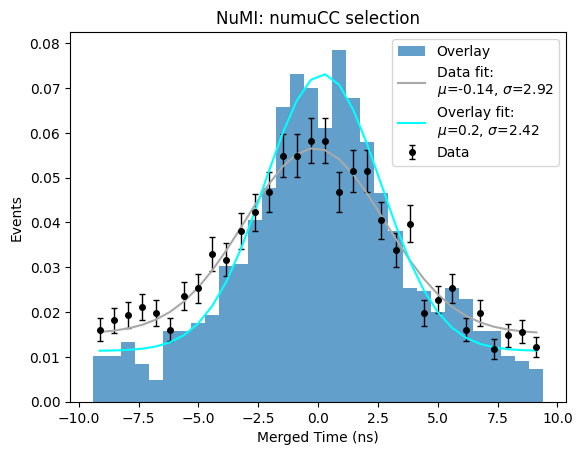

In [42]:
nbins = 32

emulate_ext = True

data = df_numi_new_data.query("merge_time_linear>-9.42 and merge_time_linear<9.42 and numu_score>0.9")["merge_time_linear"].to_numpy()
y,xbins = np.histogram(data,bins=nbins,range=(-9.42, 9.42))

#only using overlay for now, eventually we can move towards a full data to MC comparison that includes EXT and Dirt
overlay = df_numi_new_mc.query("merge_time_linear>-9.42 and merge_time_linear<9.42 and numu_score>0.9")["merge_time_linear"].to_numpy()
#weights = df_numi_new_mc.query("merge_time_new>-9.42 and merge_time_new<9.42 and numu_score>0.9")["net_weight"].to_numpy()
weights = np.ones_like(df_numi_new_mc.query("merge_time_linear>-9.42 and merge_time_linear<9.42 and numu_score>0.9")["merge_time_linear"].to_numpy())
if(emulate_ext):
    ext = np.random.uniform(-9.42, 9.42, size=int(len(overlay)*0.1))
    overlay = np.concatenate((overlay,ext))
weight = np.ones_like(overlay)*len(data)/len(overlay)
y_overlay,xbins = np.histogram(overlay,bins=nbins,range=(-9.42, 9.42),weights=weight)

x = get_bin_centers(xbins)

popt_overlay,pcov = curve_fit(gaus,x,y_overlay/np.sum(y))
print("overlay: Gaussian      mean:",round(popt_overlay[1],4),"  std:",round(popt_overlay[2],4),"  C:",round(popt_overlay[3],4))

popt,pcov = curve_fit(gaus,x,y/np.sum(y))
print("data: Gaussian      mean:",round(popt[1],4),"  std:",round(popt[2],4),"  C:",round(popt[3],4))


plt.figure()
plt.title("NuMI: numuCC selection")
plt.errorbar(get_bin_centers(xbins),y/np.sum(y),yerr=np.sqrt(y)/np.sum(y),ms=8, lw=1,fmt='.',ecolor = 'black',color='black', capsize=2, capthick=1, label="Data")
plt.hist(overlay,bins=nbins,alpha=0.7,range=(-9.42, 9.42),label='Overlay',weights=weight/np.sum(y))
plt.plot(x,gaus(x,*popt),color='darkgray',label='Data fit:'+'\n'+f"$\mu$={round(popt[1],2)}, $\sigma$={round(abs(popt[2]),2)}")
plt.plot(x,gaus(x,*popt_overlay),color='cyan',label='Overlay fit:'+'\n'+f"$\mu$={round(popt_overlay[1],2)}, $\sigma$={round(abs(popt_overlay[2]),2)}")
plt.ylabel("Events")
plt.xlabel("Merged Time (ns)")
plt.legend()
plt.show()

In [43]:
#comparison of the "linear extrapolation" and the "start and endpoints only"?